In [1]:
# Tasks
# - Define what is drawing (replace pixel values with another value)
# - How to find corners on the input image
# - draw line between two points
# - Extract the region between lines

In [2]:
# import required libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import imutils

In [3]:
# User defined functions
# Reference: https://pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect


def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

In [4]:
# Load an image to play with
cwd = os.getcwd()
image_path = cwd + "/images/sample_driver_license.jpg"
image = cv2.imread(image_path)
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

In [5]:
# Pre-processing operations
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 45, 150)

STEP 1: Edge Detection


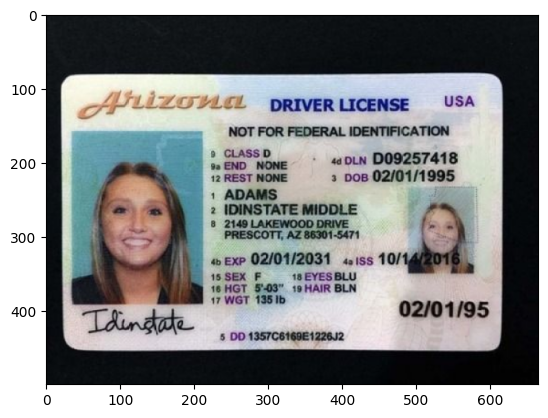

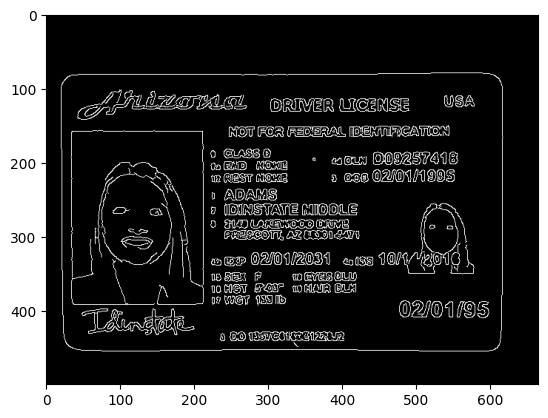

In [6]:
# Display filtered images

print("STEP 1: Edge Detection")
plt.imshow(image[...,::-1])
plt.show()

plt.imshow(edged, cmap='gray')
plt.show()

In [7]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

In [8]:
cnts

[array([[[520,  79]],
 
        [[519,  80]],
 
        [[448,  80]],
 
        [[447,  81]],
 
        [[327,  81]],
 
        [[326,  82]],
 
        [[325,  82]],
 
        [[324,  81]],
 
        [[307,  81]],
 
        [[306,  82]],
 
        [[305,  82]],
 
        [[304,  81]],
 
        [[299,  81]],
 
        [[298,  82]],
 
        [[286,  82]],
 
        [[285,  81]],
 
        [[268,  81]],
 
        [[267,  82]],
 
        [[264,  82]],
 
        [[263,  81]],
 
        [[ 43,  81]],
 
        [[ 42,  82]],
 
        [[ 34,  82]],
 
        [[ 33,  83]],
 
        [[ 31,  83]],
 
        [[ 30,  84]],
 
        [[ 29,  84]],
 
        [[ 24,  89]],
 
        [[ 24,  90]],
 
        [[ 22,  92]],
 
        [[ 22,  93]],
 
        [[ 21,  94]],
 
        [[ 21,  96]],
 
        [[ 20,  97]],
 
        [[ 20, 181]],
 
        [[ 21, 182]],
 
        [[ 21, 345]],
 
        [[ 22, 346]],
 
        [[ 22, 406]],
 
        [[ 23, 407]],
 
        [[ 23, 431]],
 
        [[ 24, 4

In [9]:
len(cnts[0])

111

In [10]:
# loop over the contours to find the best points
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

In [11]:
screenCnt

array([[[612,  87]],

       [[ 29,  84]],

       [[ 27, 445]],

       [[606, 453]]], dtype=int32)

STEP 2: Find contours of the sample driver license


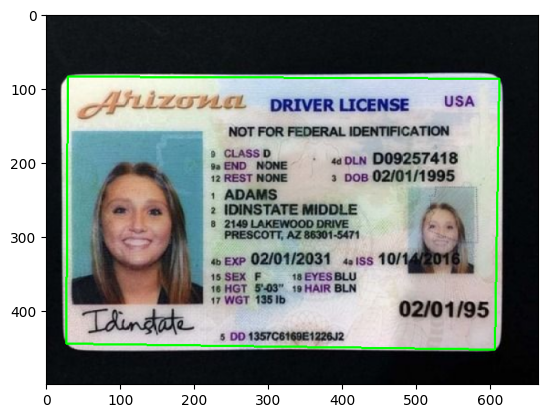

In [12]:
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of the sample driver license")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image[...,::-1])
plt.show()

In [13]:
# Warp the remaining content
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

In [14]:
warped.shape

(296, 472, 3)

In [15]:
# Convert to grayscale, because we are going to process on single channel
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

In [16]:
# Normalize the pixel values into the 0-255 or min-max region
T = threshold_local(warped, 11, offset=10, method="gaussian")

In [17]:
# Normalized pixel values compared with the warped image
warped = (warped > T).astype("uint8") * 255

In [18]:
warped.shape

(296, 472)

STEP 3: Apply perspective transform


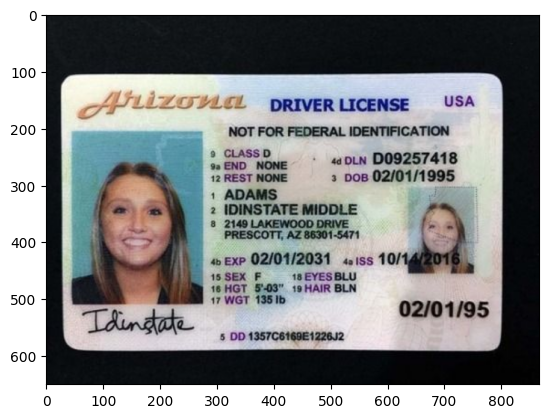

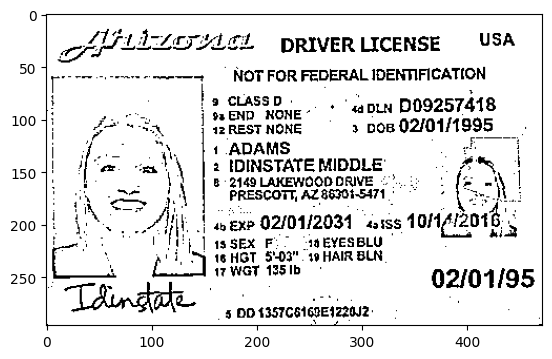

In [19]:
# Display the resultant images

print("STEP 3: Apply perspective transform")
plt.imshow(imutils.resize(orig[...,::-1], height=650))
plt.show()

# plt.imshow(imutils.resize(warped, height=650), cmap='gray')
plt.imshow(warped, cmap='gray')
plt.show()